### Imports

In [1]:
import os
from helper_fun import plot_labels, plot_imgs

import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

from collections import Counter
from PIL import Image
from skimage import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

### Hyperparameters

In [2]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
IMG_RESIZE = 256 # ResNet50 requires 256 input
LEARNING_RATE = 1e-4

### Loading data

In [3]:
train_dir = 'data/train-calibrated-shuffled.txt'
test_dir = 'data/test-calibrated-shuffled.txt'
val_dir = 'data/val-calibrated-shuffled.txt'

labels_dir = 'data/msl_synset_words-indexed.txt'

train_df = pd.read_csv(train_dir, delimiter=' ', names=['Img_paths', 'Labels'])
test_df = pd.read_csv(test_dir, delimiter=' ', names=['Img_paths', 'Labels'])
val_df = pd.read_csv(val_dir, delimiter=' ', names=['Img_paths', 'Labels'])

labels_df = pd.read_csv(labels_dir, delimiter='      ', names=['Num', 'Lab'], engine='python')

### Data exploration

In [4]:
print(f"Datasets size:\n- training: {len(train_df)} images\n- test: {len(test_df)} images\n- validation: {len(val_df)} images")

Datasets size:
- training: 3746 images
- test: 1305 images
- validation: 1640 images


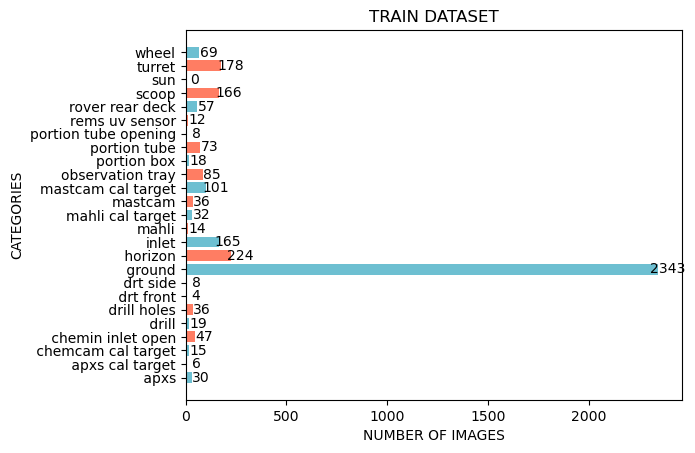

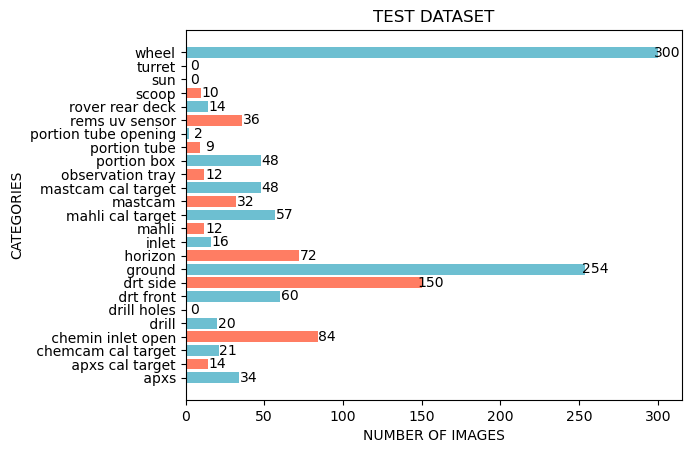

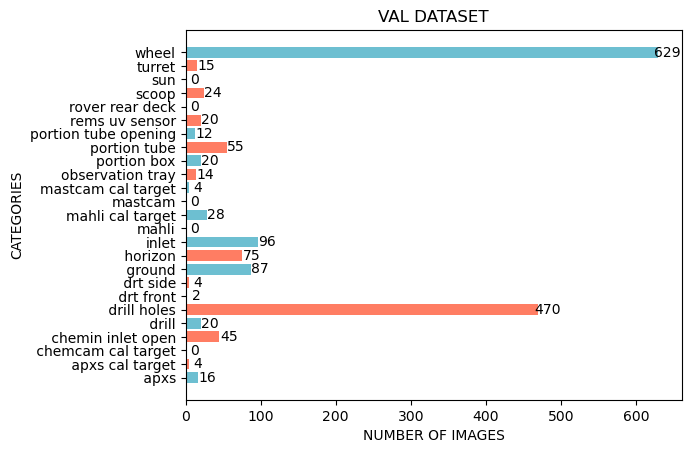

In [5]:
plot_labels(train_dir, labels_dir)
plot_labels(test_dir, labels_dir)
plot_labels(val_dir, labels_dir)

Due to the high unbalance of categories in datasets, it is decided to merge them to prevent 'ground' class overfit.

Text(0, 0.5, 'CATEGORIES')

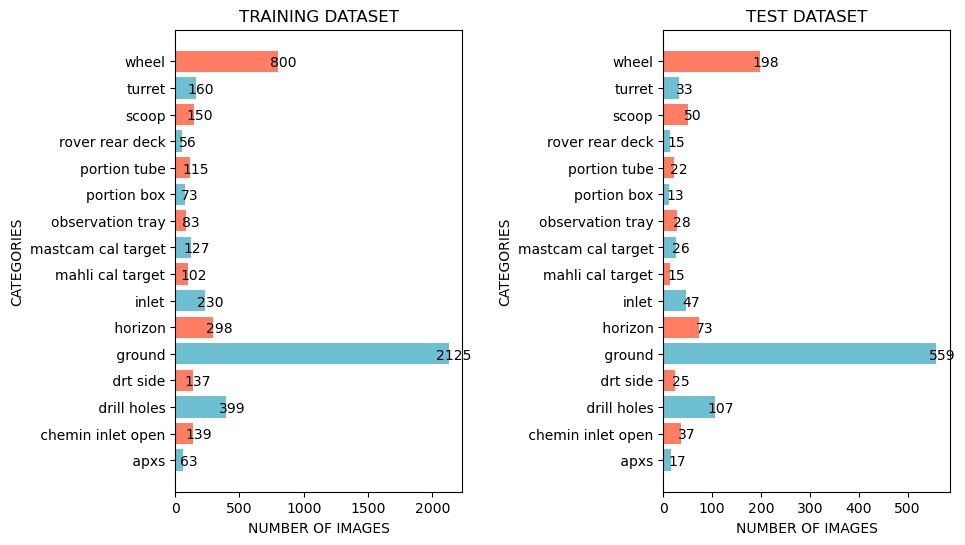

In [6]:
# Merge train, test and validation datasets
merged_df = pd.concat([train_df, test_df, val_df], ignore_index=True)

# Drop classes with less than 70 images
merged_df = merged_df[merged_df['Labels'].map(merged_df['Labels'].value_counts()) > 70]

# Split merged dataset into train and test
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

lab_num_train = Counter(train_df['Labels'])
lab_num_test = Counter(test_df['Labels'])
not_to_drop = list(lab_num_train.keys())
not_to_drop.sort()
lab_df = labels_df[labels_df['Num'].isin(not_to_drop)]

colors = ['#6DBFD1', '#FF7D63']
fig, ax = plt.subplots(1, 2, figsize=(10,6))
fig.subplots_adjust(wspace=0.7)

x_train = [i for i in (lab_df['Lab'].tolist())]
x_test = [i for i in (lab_df['Lab'].tolist())]
y_train =[lab_num_train[i] for i in not_to_drop]
y_test =[lab_num_test[i] for i in not_to_drop]

ax[0].barh(x_train, y_train, color=colors)
for i, v in enumerate(y_train):
    ax[0].text(v+max(y_train)*0.02, i-0.2, f'{v}', ha='center')
ax[0].set_title("TRAINING DATASET")
ax[0].set_xlabel('NUMBER OF IMAGES')
ax[0].set_ylabel('CATEGORIES')

ax[1].barh(x_test, y_test, color=colors)
for i, v in enumerate(y_test):
    ax[1].text(v+max(y_test)*0.02, i-0.2, f'{v}', ha='center')
ax[1].set_title("TEST DATASET")
ax[1].set_xlabel('NUMBER OF IMAGES')
ax[1].set_ylabel('CATEGORIES')

### Dataset & Dataloader

In [7]:
# 3 transform functions are needed for different purposes

# Transform for color images
data_transform = transforms.Compose([
    transforms.Resize(size=(IMG_RESIZE, IMG_RESIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

# Transform for grayscale images
grayscale_transform = transforms.Compose([
    transforms.Resize(size=(IMG_RESIZE, IMG_RESIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

# Transform for plotting
simple_transform = transforms.Compose([
    transforms.Resize(size=(IMG_RESIZE, IMG_RESIZE)),
    transforms.ToTensor()])

In [8]:
class CuriosityDataset(Dataset):
    """ Custom dataset for Curiosity rover images"""
    
    def __init__(self, df, root_dir, transform=None, gray_transform=None) -> None:
        self.dataset_df = df
        self.root_dir = root_dir
        self.transform = transform
        self.gray_transform = gray_transform

    def __len__(self) -> int:
        return len(self.dataset_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir, self.dataset_df.iloc[idx, 0])
        image = Image.open(img_path)

        label = int(self.dataset_df.iloc[idx, 1])
        
        if self.transform and (image.mode == 'RGB'):
            image = self.transform(image)
        
        if self.gray_transform and (image.mode == 'L'):
            image = self.gray_transform(image)
        
        return image, label


train = CuriosityDataset(df=train_df, root_dir='data/', transform=data_transform, gray_transform=grayscale_transform)
test = CuriosityDataset(df=test_df, root_dir='data/', transform=data_transform, gray_transform=grayscale_transform)

In [9]:
train_dataloader = DataLoader(dataset=train, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, 
                              shuffle=True)

test_dataloader = DataLoader(dataset=test, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

In [10]:
images, lab = next(iter(train_dataloader))
print(f"Image shape: {images.shape}\n {torch.min(images)}\n {torch.max(images)}")
print(f"Labels: {lab}")

Image shape: torch.Size([32, 3, 256, 256])
 -2.1179039478302
 2.640000104904175
Labels: tensor([24, 24, 24,  8,  9,  8,  7, 12,  8,  8, 12,  5,  8, 24, 24,  8,  8,  3,
        21,  8, 16,  3, 15,  9,  8, 20,  7, 10, 24, 12,  9,  7])


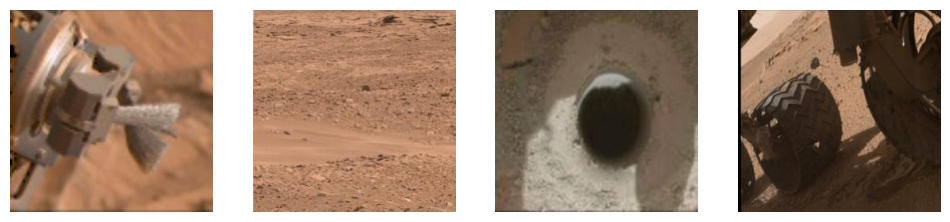

In [11]:
train_plot = CuriosityDataset(df=train_df, root_dir='data/', transform=simple_transform)
plot_imgs(dataset=train_plot, imgs_num=4, labels_dir=labels_dir)

## Model

In [19]:
weights = models.ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=2048, out_features=256, bias=True),
            nn.ReLU(),   
            nn.Linear(in_features=256, out_features=25, bias=True) # 25 output classes because classes numbers were not reindexed after drop - need to be fixed
            )

model = model.to(device)
summary(model, input_size=[BATCH_SIZE, 3, IMG_RESIZE, IMG_RESIZE])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 25]                  --
├─Conv2d: 1-1                            [32, 64, 128, 128]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 128, 128]        (128)
├─ReLU: 1-3                              [32, 64, 128, 128]        --
├─MaxPool2d: 1-4                         [32, 64, 64, 64]          --
├─Sequential: 1-5                        [32, 256, 64, 64]         --
│    └─Bottleneck: 2-1                   [32, 256, 64, 64]         --
│    │    └─Conv2d: 3-1                  [32, 64, 64, 64]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 64, 64]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 64, 64]          --
│    │    └─Conv2d: 3-4                  [32, 64, 64, 64]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 64, 64]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 64, 64]   

In [20]:
def train_step(model, dataloader, loss_fn, optimizer):
    
    model.train()
    train_loss, train_acc = 0, 0
        
    for batch, (img, y) in enumerate(dataloader):
        
        img, y = img.to(device), y.to(device)
        
        y_pred = model(img)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

def test_step(model, dataloader, loss_fn):
    
    model.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (img, y) in enumerate(dataloader):

            img, y = img.to(device), y.to(device)
            y_pred = model(img)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            
            y_pred_labels = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += ((y_pred_labels == y).sum().item()/len(y_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [21]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs):

    results = {"train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"train_acc: {train_acc:.2f}% | "
              f"test_acc: {test_acc:.2f}% | ")

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)
        results["train_accuracy"].append(train_acc)
        results["test_accuracy"].append(test_acc)

    return results

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

NUM_EPOCHS = 5

In [ ]:
model_results = train(model=model.to(device), 
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=criterion, 
                      epochs=NUM_EPOCHS)

### Evaluation

Text(0, 0.5, 'Accuracy')

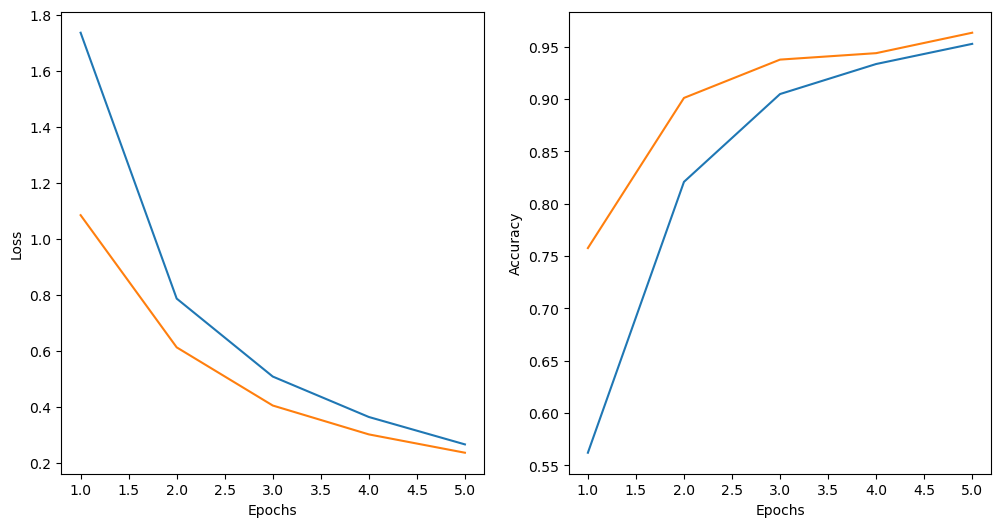

In [26]:
result_df = pd.DataFrame({
    'Train Loss': model_results['train_loss'],
    'Test Loss': model_results['test_loss'],
    'Train Acc': model_results['train_accuracy'],
    'Test Acc': model_results['test_accuracy']})
    
epochs = [*range(1, NUM_EPOCHS+1, 1)]
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(epochs, result_df['Train Loss'], epochs, result_df['Test Loss'])
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(epochs, result_df['Train Acc'], epochs, result_df['Test Acc'])
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")

  0%|          | 0/40 [00:00<?, ?it/s]

Text(120.7222222222222, 0.5, 'True labels')

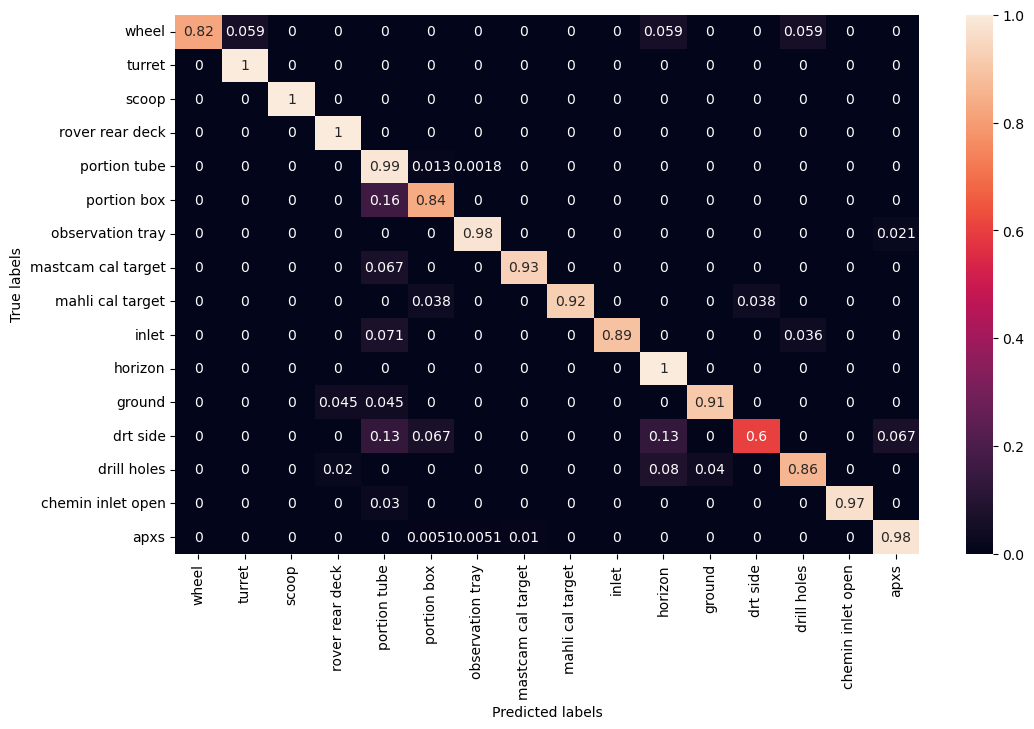

In [33]:
y_pred, y_true = [], []

for inputs, labels in tqdm(test_dataloader):
        output = model(inputs) 

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 

class_names = ('wheel', 'turret', 'scoop','rover rear deck', 'portion tube','portion box','observation tray','mastcam cal target',
           'mahli cal target','inlet','horizon','ground','drt side','drill holes','chemin inlet open','apxs')

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')